# Conventions and interoperability

## Conventions for template matching
Template matching in pyxem is typically used to determine the orientation of diffraction patterns. This orientation gives not only the zone axis, but also the in-plane rotation.

An orientation is a rotation from a reference orientation, for a given crystal symmetry. To describe the orientation of a crystal, two coordinate systems are needed: the sample (or lab) reference frame and the crystal reference frame. The sample reference frame ($X_s, Y_s, Z_s$) and crystal reference frame ($X_c, Y_c, Z_c$) are in practice used to describe orientations, and not positions within the sample or crystal. They can therefore be called orientation or Euler reference frames. In pyxem, the sample reference frame is in practice fixed to the edges of the diffraction pattern, while the crystal reference frame is fixed to the crystal unit cell.

### Euler angles
Rotations and orientations in three dimensions can be described using Euler angles. Pyxem uses the Bunge convention for Euler angles:
1. Rotations and coordinate systems are right-handed.
2. Rotations are passive (also known as intrinsic), meaning that it is the coordinate axes that rotate.
3. Euler angles ($\phi_1$, $\Phi$, $\phi_2$) are given in the form ZX'Z''.
4. Euler angles rotate the sample reference frame to the crystal reference frame ("lab2crystal").

The sample reference frame is first rotated $\phi_1$ around $Z_s$ (the sample Z-axis), followed by $\Phi$ around the new $X_s$, followed by $\phi_2$ around the updated $Z_s$. If $\phi_1=\Phi=\phi_2=0$, the sample reference frame is aligned with the crystal reference frame.

We can illustrate this convention using diffsims (the package used to simulate diffraction patterns used for template matching) for some simple orientations. First we create the structure (using cubic aluminium as an example):

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import diffpy
from diffsims.generators.diffraction_generator import DiffractionGenerator

latt = diffpy.structure.lattice.Lattice(4,4,4,90,90,90)
atoms = [diffpy.structure.atom.Atom(atype='Al',xyz=[0.0,0.0,0.0],lattice=latt),
         diffpy.structure.atom.Atom(atype='Al',xyz=[0.5,0.5,0.0],lattice=latt),
         diffpy.structure.atom.Atom(atype='Al',xyz=[0.5,0.0,0.5],lattice=latt),
         diffpy.structure.atom.Atom(atype='Al',xyz=[0.0,0.5,0.5],lattice=latt)]
structure_matrix = diffpy.structure.Structure(atoms=atoms,lattice=latt)

We can then simulate a diffraction pattern for the orientation (10&deg;, 0, 0) in Euler angles:

In [2]:
scale = 0.027; half_shape = 64; rec_rad = scale * half_shape; phi1 = 10
diff_gen = DiffractionGenerator(accelerating_voltage=200,
                                precession_angle=0,
                                scattering_params='xtables',
                                shape_factor_model="linear",
                                minimum_intensity=0.01,
                                )
sim = diff_gen.calculate_ed_data(structure_matrix, reciprocal_radius=rec_rad,
                                rotation=(phi1, 0, 0), with_direct_beam=True,
                                max_excitation_error=0.04)

and plot the diffsims simulation with labeled diffraction spots:

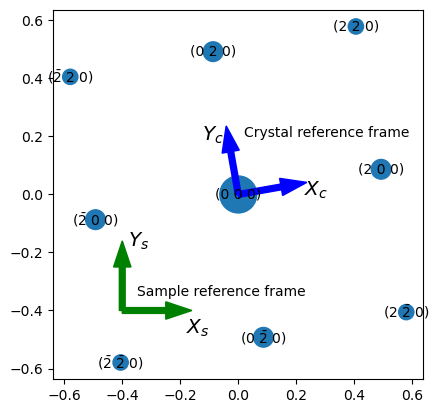

In [3]:
fig, axs = plt.subplots()
axs.set_aspect("equal")
sim.plot(size_factor=30, show_labels=True, ax=axs)
# Draw coordinate systems
length = 0.15
width = 0.02
axs.arrow(-0.4, -0.4, length, 0, width=width, color="g")
axs.arrow(-0.4, -0.4, 0, length, width=width, color="g")
axs.text(-0.18, -0.48, "$X_s$", fontsize="x-large")
axs.text(-0.38, -0.18, "$Y_s$", fontsize="x-large")
axs.text(-0.35, -0.35, "Sample reference frame")
dx = length * np.cos(np.deg2rad(phi1))
dy = length * np.sin(np.deg2rad(phi1))
axs.arrow(0, 0, dx, dy, width=width, color="b")
axs.text(dx+0.08, dy-0.03, "$X_c$", fontsize="x-large")
dx = length * np.cos(np.deg2rad(phi1+90))
dy = length * np.sin(np.deg2rad(phi1+90))
axs.arrow(0, 0, dx, dy, width=width, color="b")
axs.text(dx-0.1, dy+0.04, "$Y_c$", fontsize="x-large")
axs.text(0.02, 0.2, "Crystal reference frame");

Pyxem uses the same conventions as illustrated by this `diffsims.sims.Simulation.plot()` plot.
Arrows are added to the plot to show the orientation reference frames. The sample reference frame (shown in green, $Z_s$ pointing out of the screen) is fixed with respect to the edges of the diffraction pattern. The crystal reference frame (shown in blue) is fixed to the <100> directions of the cubic unit cell.

We see that the sample reference frame must be rotated 10&deg; counter-clockwise around
the sample Z-axis to align the sample reference frame with the crystal reference frame. Hence, the orientation of the diffraction pattern is (10&deg;, 0, 0) in Euler angles.

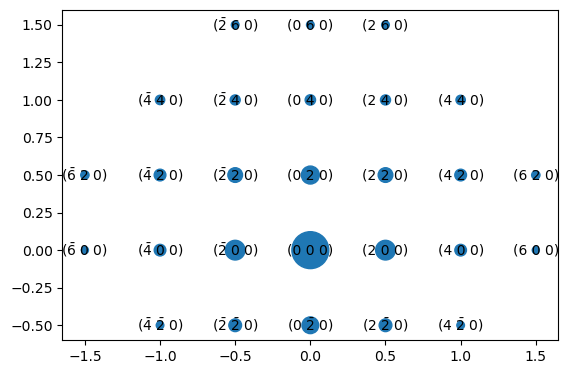

In [4]:
diff_gen = DiffractionGenerator(accelerating_voltage=200,
                                precession_angle=0,
                                scattering_params='xtables',
                                shape_factor_model="linear",
                                minimum_intensity=0.001,
                                )
diff_gen.calculate_ed_data(structure_matrix, reciprocal_radius=rec_rad,
                                rotation=(0, 2, 0), with_direct_beam=True,
                                max_excitation_error=0.04).plot(size_factor=30, show_labels=True);

Above is the simulated diffraction pattern for the Euler angle orientation (0, 2&deg;, 0).
`minimum_intensity` was decreased to include more diffraction spots. We see that a 2&deg; counter-clockwise rotation around $X_s$ (pointing to the right) gives stronger spots in the upper part of the diffraction pattern, since the corresponding reciprocal lattice rods are closer to the Ewald sphere there.

### Experimental diffraction patterns
We have seen that the diffraction patterns simulated by diffsims have the sample reference frame oriented with $X_s$ pointing to the right, $Y_s$ pointing up, and $Z_s$ pointing out of the screen. However, in Matplotlib, Hyperspy and pyxem, images (including diffraction patterns) are typically plotted with the origin in the top-left corner and the y-axis pointing *down*. When comparing a diffraction pattern stored as a numpy/dask array with simulated diffraction patterns during template matching, care must be taken. In pyxem, we assume that the pyxem/hyperspy signal or numpy array to be template matched is oriented correctly when plotted with the x-axis ($X_\text{Signal2D}$) pointing to the right and the y-axis ($Y_\text{Signal2D}$) pointing *down*.

### Scanning electron diffraction
The sample reference frame is fixed to the edges of the diffraction pattern. These are often *not* parallel to the scan directions in a scanning electron diffraction (i.e., 4D) dataset. If the in-plane orientation of the diffraction patterns is of interest, care must be taken to modify the in-plane rotation ($\phi_1$) to compensate for this. Pyxem uses the same convention as hyperspy for the navigation axes: x-axis to the right and the y-axis down.

### Cartesian crystal reference frame
For convenience, it is standard to always use a Cartesian crystal reference frame even when the crystal lattice is not cubic. The choice of Cartesian reference frame is relatively straightforward for crystal systems with orthogonal lattice vectors, but for the other crystal systems (triclinic, monoclinic, trigonal, hexagonal) there is no obvious choice. Since the diffraction pattern templates are created by diffsims, the convention used by diffsims determines the convention of pyxem:

$\mathbf{X_c} || \mathbf{a^*}/a^*$, $\mathbf{Y_c} || \mathbf{Z_c} \times \mathbf{X_c}$, $\mathbf{Z_c} || \mathbf{c}/c$.

### Reference frame summary
To sum up, here are the reference frames involved when doing template matching to determine the orientation of diffraction patterns:
1. Crystal unit cell: $a, b, c, \alpha, \beta, \gamma$
2. Cartesian crystal reference frame (fixed to the unit cell): $X_c, Y_c, Z_c$
3. Sample reference frame (parallel to the edges of the diffraction pattern): $X_s, Y_s, Z_s$
4. Hyperspy `Signal2D` reference frame used for (experimental) diffraction patterns (similar to 3., but the y-axis is reversed): $X_\text{Signal2D}, Y_\text{Signal2D}$
5. Scan reference frame (assumed to have the same orientation as 4., but the in-plane orientation can be modified to compensate if this is not the case): $X_\text{scan}, Y_\text{scan}$

The different reference frames are shown in the figure below. Note the TEM convention of viewing the diffraction pattern from above (i.e., looking from the electron source to the detector).

<img src="ref_frames.png" alt="Reference frames"/>

### Interoperability

#### Importing into MTEX
An ANG file created from an orix CrystalMap can be imported into MTEX using a script such as the one shown below.
Here the scan direction was the one typically used in scanning electron diffraction and STEM (scanning from left to right starting in the top-left corner). Since MTEX requires the sample reference frame and the scan reference frame to have the same orientation, the Euler angles are modified using `convertEuler2SpatialReferenceFrame`.

```
filename = 'example.ang';
plotx2east;
plotzIntoPlane;
CS_Al = crystalSymmetry('432', [4 4 4], 'X||a*', 'Z||c', 'mineral', 'Al');
CS = {'not_indexed', CS_Al};
ebsd = EBSD.load(filename, CS, 'interface', 'ang', 'convertEuler2SpatialReferenceFrame', 'setting 3');
ebsd.scanUnit = 'nm';
```

Instead of using `'convertEuler2SpatialReferenceFrame', 'setting 3'` when loading the ANG file, the following commands can be used:
```
rot = rotation.byAxisAngle(xvector, 180*degree);
ebsd_rot = rotate(ebsd, rot, 'keepXY');
```          